In [1]:
# Feedforward Neural Network on CIFAR-10
# Step a: Import necessary packages

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# This cell sets a random seed so the results are the same every time you run the notebook.

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [4]:
# Step b: Load the training and testing data
# CIFAR-10 → 60 000 color images (32×32×3), 10 classes

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)




Train: (50000, 32, 32, 3) (50000, 1)
Test : (10000, 32, 32, 3) (10000, 1)


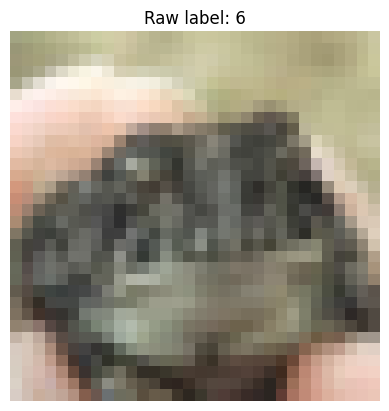

In [5]:
# Display a sample image
plt.imshow(x_train[25])
plt.title(f"Raw label: {y_train[25][0]}")
plt.axis("off")
plt.show()

In [6]:
# Step c1: Preprocess images and labels

# Scale pixel values → [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

print("Normalized data shape:", x_train.shape, x_test.shape)

# One-hot encode labels → (50000, 10), (10000, 10)
num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

print("One-hot label shape:", y_train.shape, y_test.shape)


# ➡ Converts pixel values (0–255) → (0–1) range for better learning.
# ➡ Flattens each image (32×32×3 = 3072 numbers).
# Now each image becomes a long vector of 3072 values.


Normalized data shape: (50000, 32, 32, 3) (10000, 32, 32, 3)
One-hot label shape: (50000, 10) (10000, 10)


In [7]:
# Step c2: Define Feedforward Neural Network Architecture (CNN layers + dense layers)

model = models.Sequential([
    # Convolution & Pooling Layers
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),

    # Fully connected Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes
])

# Compile the model using SGD as required
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show architecture
model.summary()


# ➡ Sequential: stack layers in order
# ➡ Dense layers: fully connected neurons
# ➡ ReLU: makes the network learn non-linear features
# ➡ Softmax: converts outputs into class probabilities (for 10 categories)


C:\Users\SAHIL KULKARNI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step d: Train the model using SGD
# use validation data = test set for simplicity (assignment style)

batch_size = 30
epochs = 10

# New Keras format fix (.keras)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_cifar_model.keras",
    save_best_only=True,
    monitor="val_loss"
)

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[checkpoint_cb],
    verbose=2
)

# This cell trains the model on the training data and stores the accuracy and loss after each epoch.

# ➡ Optimizer: SGD (updates weights to reduce error gradually)
# ➡ Loss: measures how wrong predictions are
# ➡ Metrics: accuracy (performance indicator)
# •	Epochs: how many times it sees all images
# •	Batch size: number of images processed together
# •	Validation split: 10% used for checking accuracy after each epoch.



Epoch 1/10
1667/1667 - 30s - 18ms/step - accuracy: 0.3982 - loss: 1.6463 - val_accuracy: 0.5206 - val_loss: 1.3393
Epoch 2/10
1667/1667 - 27s - 16ms/step - accuracy: 0.5634 - loss: 1.2248 - val_accuracy: 0.5927 - val_loss: 1.1595
Epoch 3/10
1667/1667 - 23s - 14ms/step - accuracy: 0.6276 - loss: 1.0554 - val_accuracy: 0.6316 - val_loss: 1.0588
Epoch 4/10
1667/1667 - 21s - 12ms/step - accuracy: 0.6694 - loss: 0.9413 - val_accuracy: 0.6407 - val_loss: 1.0390
Epoch 5/10
1667/1667 - 20s - 12ms/step - accuracy: 0.6974 - loss: 0.8660 - val_accuracy: 0.6430 - val_loss: 1.0881
Epoch 6/10
1667/1667 - 20s - 12ms/step - accuracy: 0.7169 - loss: 0.8024 - val_accuracy: 0.6418 - val_loss: 1.1184
Epoch 7/10
1667/1667 - 20s - 12ms/step - accuracy: 0.7390 - loss: 0.7463 - val_accuracy: 0.6288 - val_loss: 1.1821
Epoch 8/10
1667/1667 - 20s - 12ms/step - accuracy: 0.7517 - loss: 0.7019 - val_accuracy: 0.6482 - val_loss: 1.1361
Epoch 9/10
1667/1667 - 20s - 12ms/step - accuracy: 0.7614 - loss: 0.6741 - val_a

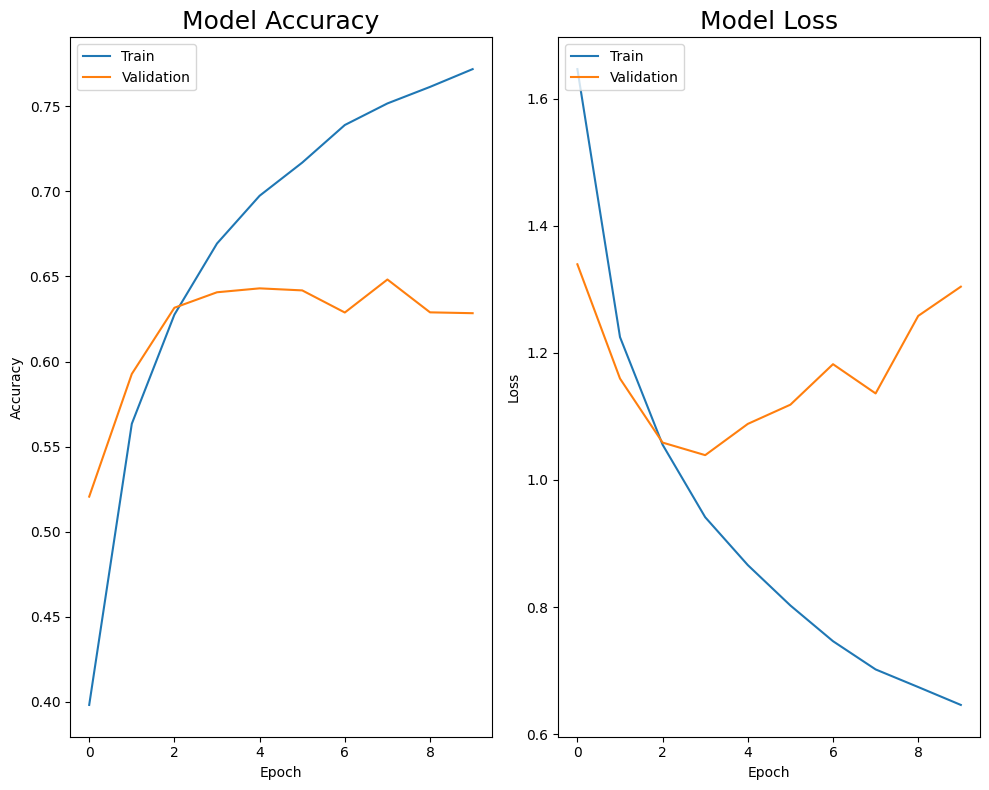

In [9]:
# Step f: Visualize training progress (loss + accuracy)

plt.figure(figsize=(10,8))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'], loc='upper left')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=18)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
# Step e: Evaluate the model on test data

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss = {test_loss:.4f}")
print(f"Test Accuracy = {test_acc:.4f}")


Test Loss = 1.3040
Test Accuracy = 0.6284


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Predictions shape: (10000, 10)


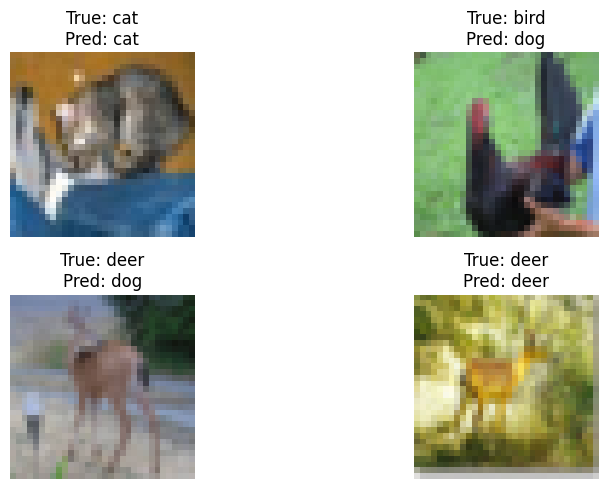

In [11]:
# Step g: Qualitative evaluation of predictions

predictions = model.predict(x_test)
print("Predictions shape:", predictions.shape)

# Show few predicted samples
plt.figure(figsize=(10,5))
for i, idx in enumerate([0, 25, 100, 500]):
    plt.subplot(2,2,i+1)
    plt.imshow(x_test[idx])
    pred_label = class_names[np.argmax(predictions[idx])]
    true_label = class_names[np.argmax(y_test[idx])]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# This cell evaluates the model on the test dataset and prints its accuracy and loss.
# It also predicts some test images and shows their predicted labels.


In [12]:
# Save final trained model for reuse
model.save("final_cifar_ffn.keras")
print("Model saved successfully.")
# This cell saves the trained model and defines a helper function to make predictions on single images.

Model saved successfully.


In [13]:
# 🧩 Aim
# To implement and train a Feedforward Neural Network (FFN) on the CIFAR-10 dataset using Keras and TensorFlow,
# and evaluate its performance using Stochastic Gradient Descent (SGD) optimizer.
# ________________________________________
# 🧠 Theory (in simple language)
# •	A Feedforward Neural Network (FFN) is the simplest type of Artificial Neural Network.
# •	Information moves only in one direction — from input → hidden → output layers.
# •	Each neuron has weights and biases, and uses an activation function to decide what output to pass forward.
# •	The model learns by adjusting weights so that its predicted outputs match the correct labels (using a loss function).
# For CIFAR-10:
# •	Input: image pixels (32×32×3 = 3072 numbers)
# •	Hidden Layers: detect color and texture patterns
# •	Output: 10 neurons for 10 classes (softmax gives probabilities)
